In [4]:
import cv2
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, floor, ceil, nan, pi
from skimage import color, exposure
from skimage.color import rgb2gray
from skimage.feature import blob_log
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.transform import rotate
from skimage import morphology
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.color import rgb2hsv
from scipy.stats import circmean, circvar, circstd
from statistics import variance, stdev
from scipy.spatial import ConvexHull

def removeHair(img_org, img_gray, kernel_size=25, threshold=10, radius=3):
    
    # kernel for the morphological filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel_size, kernel_size))


    # perform filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)
    tophat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel)

    hat_img = cv2.add(blackhat, tophat)  # This properly merges them

    # intensify the hair countours in preparation for the inpainting algorithm
    _, thresh = cv2.threshold(hat_img, threshold, 255, cv2.THRESH_BINARY)

    # inpaint the original image depending on the mask
    img_out = cv2.inpaint(img_org, thresh, radius, cv2.INPAINT_TELEA)
    
    return hat_img, thresh, img_out

### Test 1: predicted vs computed %area of the lesion
Result: always around 49/50% ;-; doesn't appear to be working.
Ok from plotting it is clear that the masking is bad

In [1]:
def measure_pigment_network(image) -> int:
    """Computes the percentage of the (BGR) image that constitutes the foreground.
    
    :param image: The BGR image to be analysed
    :return: The % of the foreground in the image
    
    """
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, _, _ = cv2.split(lab_image)
    enhanced_l_channel = cv2.equalizeHist(l_channel)
    _, binary_mask = cv2.threshold(enhanced_l_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    total_pixels = np.prod(binary_mask.shape[:2])
    pigment_pixels = np.count_nonzero(binary_mask)

    # compute % of pixels in the lesion region
    coverage_percentage = (pigment_pixels / total_pixels) * 100

    return coverage_percentage, binary_mask

In [2]:
# predicted values
prediction = [None, '10-20% (hardly noticeable lesion)', '13-18%', '40-50%', '15-30%', '30-40%', '13-18%', '40-50%', '10-15% (huge blue marks might be a problem)', '15-20%',  '5-10% (not noticeable + pen marks)', '10-15%', '17-20%',  '25-40%', '20-25%', '5-7%', '15-20%', '50-60%', '40-50%', '5-10%', '5-10%', '5-13%', '15-20%', '45-55%', '10-20%', '15-22%']
len(prediction)

26

In [5]:
folder_path = "../../data/test"
i = 1

# list all files
image_files = sorted(os.listdir(folder_path)) 

# iterate through the images
for filename in image_files:

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    cov_perc_wh, _ = measure_pigment_network(img)
    _, _, img_noH = removeHair(img, img_gray)
    # img_scaled = rgb2gray(img_noH) * 256

    cov_perc_nh, _ = measure_pigment_network(img_noH)

    print(f'Image n{i} \nExpected coverage percentage: {prediction[i]}. \nComputed coverage percentage (with hair): {cov_perc_wh}% \nComputed coverage percentage (without hair): {cov_perc_nh}%\n')
    i += 1
    

Image n1 
Expected coverage percentage: 10-20% (hardly noticeable lesion). 
Computed coverage percentage (with hair): 49.68309569576071% 
Computed coverage percentage (without hair): 49.96229486945383%

Image n2 
Expected coverage percentage: 13-18%. 
Computed coverage percentage (with hair): 49.8859263069654% 
Computed coverage percentage (without hair): 49.690855264272045%

Image n3 
Expected coverage percentage: 40-50%. 
Computed coverage percentage (with hair): 50.68689114569771% 
Computed coverage percentage (without hair): 49.36452136289887%

Image n4 
Expected coverage percentage: 15-30%. 
Computed coverage percentage (with hair): 49.22104355640032% 
Computed coverage percentage (without hair): 49.219249877676994%

Image n5 
Expected coverage percentage: 30-40%. 
Computed coverage percentage (with hair): 50.690909266539805% 
Computed coverage percentage (without hair): 50.07268916086281%

Image n6 
Expected coverage percentage: 13-18%. 
Computed coverage percentage (with hair): 

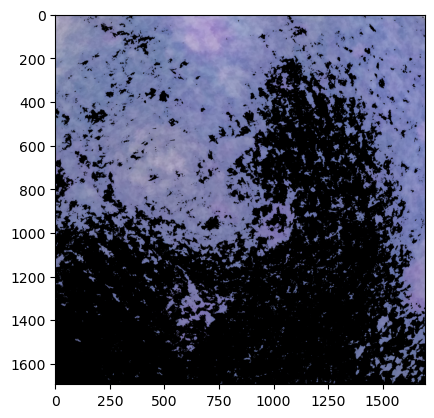

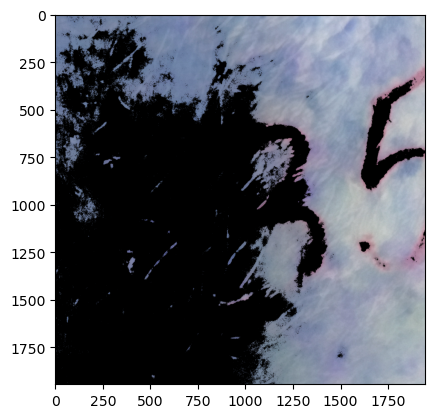

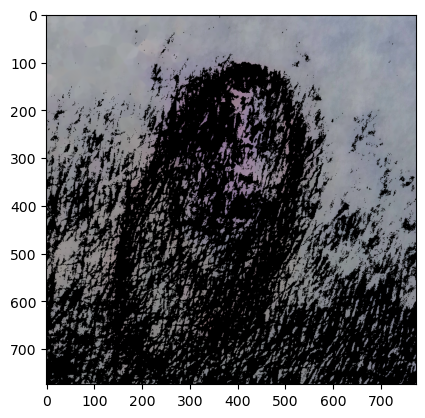

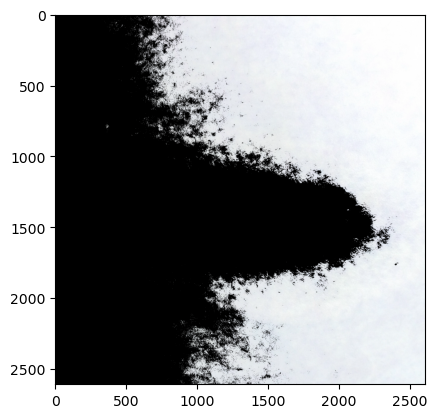

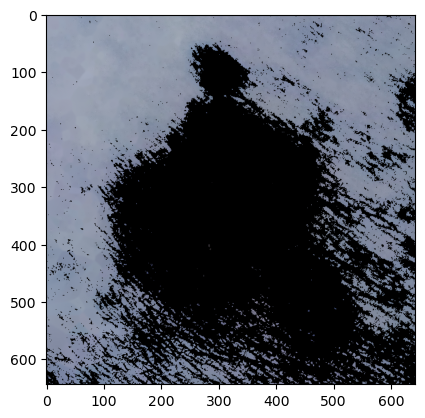

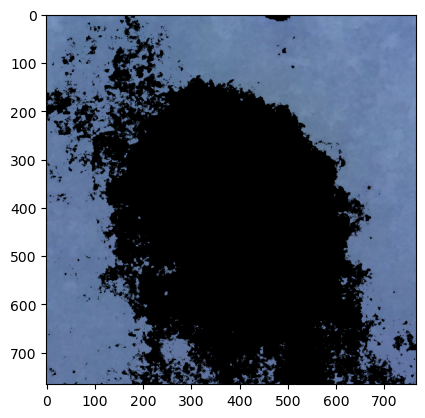

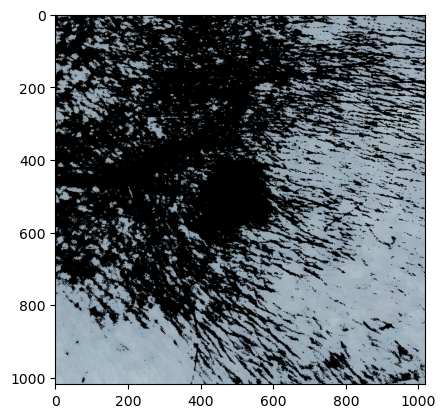

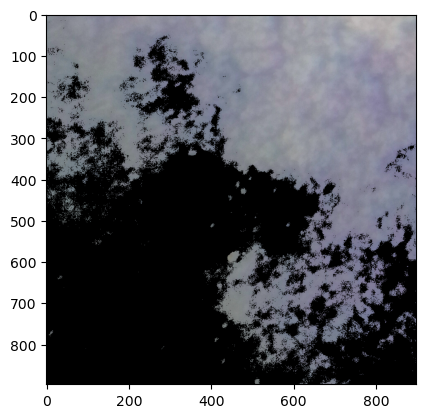

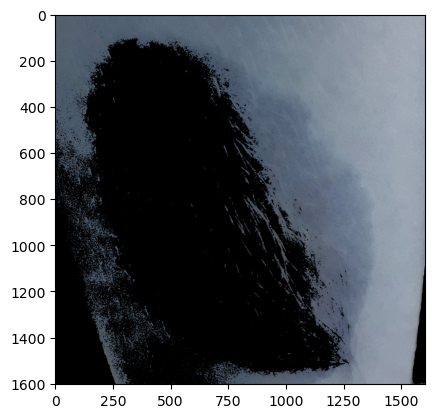

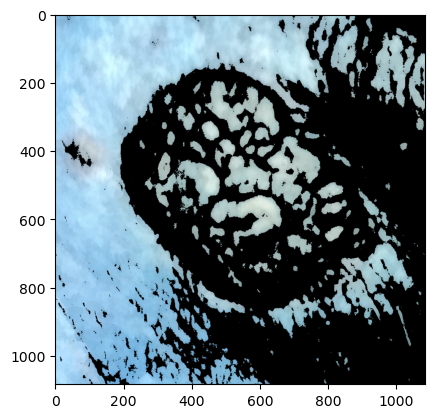

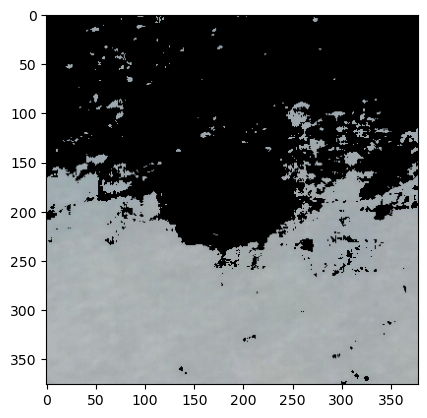

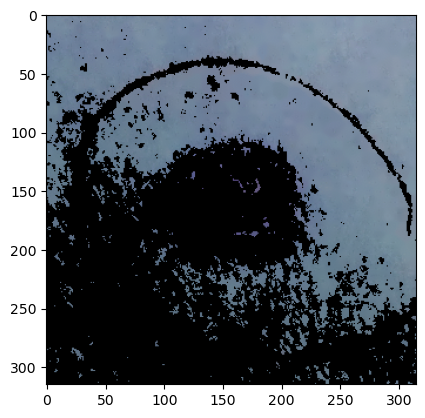

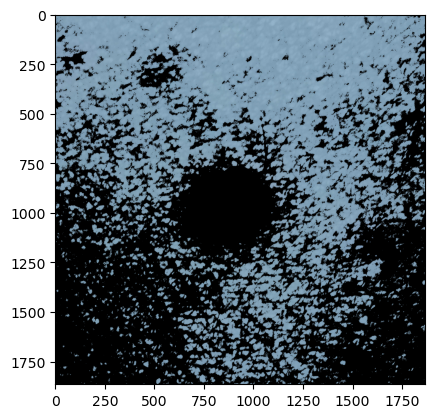

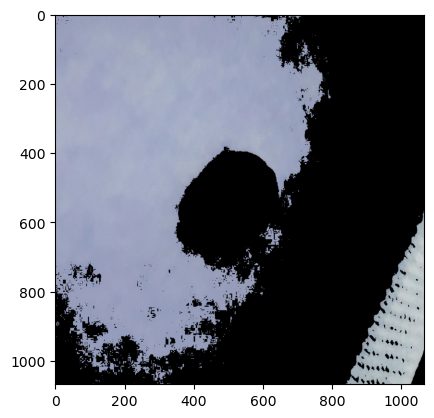

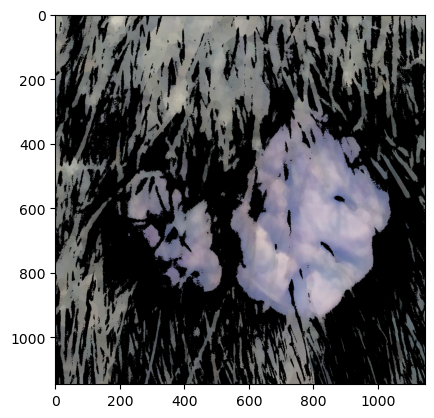

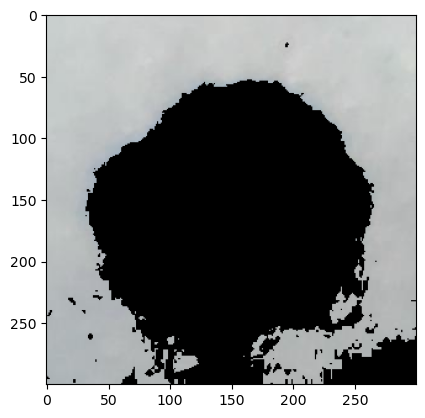

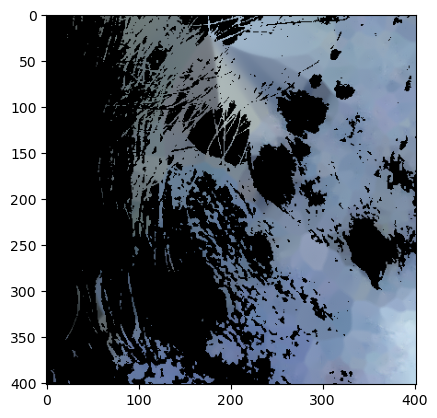

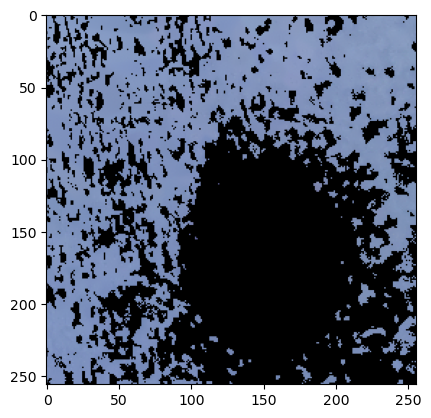

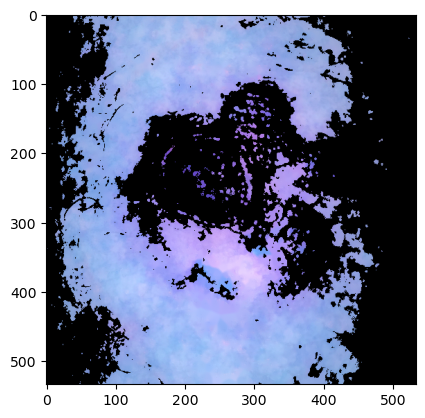

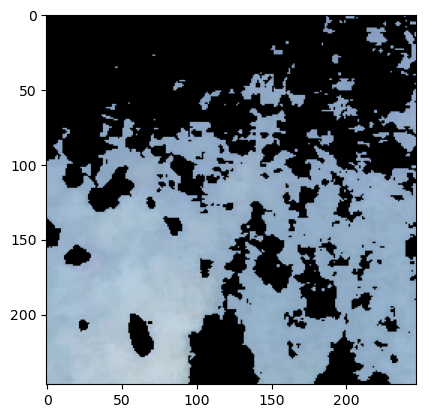

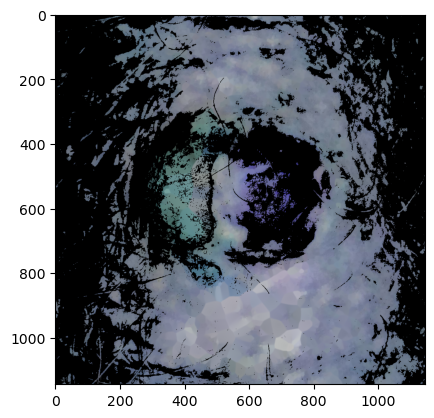

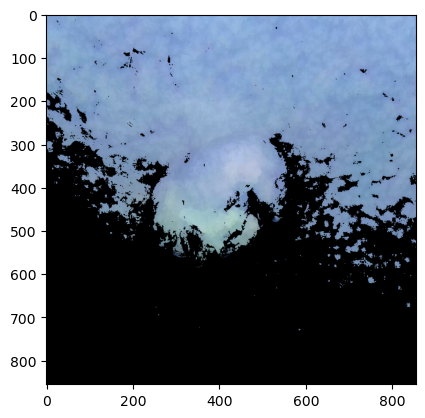

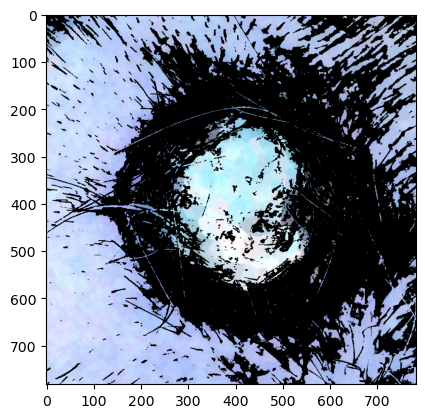

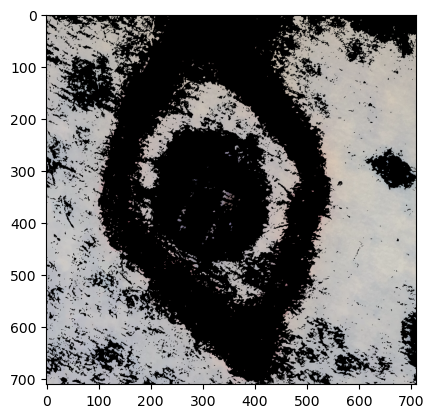

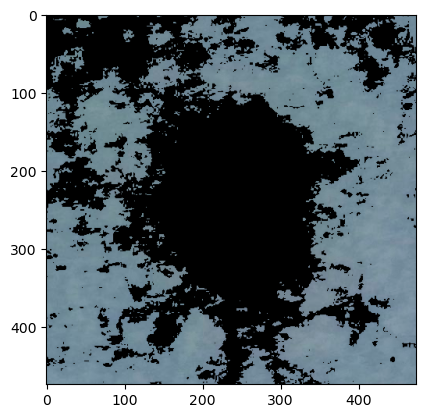

In [6]:
folder_path = "../../data/test"
i = 1

# list all files
image_files = sorted(os.listdir(folder_path)) 

# iterate through the images
for filename in image_files:

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, mask = measure_pigment_network(img)
    _, _, img_noH = removeHair(img, img_gray)
    img_noH[mask == 0] = 0
    plt.imshow(img_noH)
    plt.show()
    

## Test 2: modify function and try again
Result: the function correctly computes the percentage, but the masking is still bad

In [7]:
def mask_applier(img_rgb, img_gray):
    """Removes hair from the given image, creates and apply a mask to
    individuate the lesion.
    The grayscale image should have pixel values between 0 and 1, as they
    will be scaled up appropriately by the function.
    
    :param img_rgb: the rgb original image
    
    :param img_gray: the grayscale original image
    
    :return: hairless, masked rgb image"""

    # filter out the hair
    _, _, img_noHair = removeHair(img_rgb, img_gray)

    # scale the values appropriately (they are defaulted to be from 0 to 1)
    img_gnH = rgb2gray(img_noHair) * 255
    
    # create and refine the mask
    thresh = threshold_otsu(img_gnH)
    im_mask = img_gnH <= thresh
    struct_el = morphology.disk(2)
    mask_dilated = morphology.binary_erosion(morphology.binary_dilation(morphology.binary_dilation(im_mask, struct_el), struct_el), struct_el)

    # apply the updated mask onto the image
    img_noHair[mask_dilated==0] = 0

    return img_noHair

def measure_pigment_network_maskapplier(image) -> int:
    """Computes the percentage of the (BGR) image that constitutes the foreground.
    
    :param image: The BGR image to be analysed
    :return: The % of the foreground in the image
    
    """
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_gray = rgb2gray(img_rgb)
    img_gray = (img_gray * 255).astype(np.uint8)

    img_mask = mask_applier(img_rgb, img_gray)

    
    if img_mask.ndim == 3:
        img_mask_flat = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
    
    # Ensure mask is 2D and binary (0 or 1)
    mask_binary = (img_mask_flat > 0).astype(np.uint8)


    # Total pixels in the image (height × width)
    total_pixels = img_rgb.shape[0] * img_rgb.shape[1]
    print(f'Total pixels: {total_pixels}')

    # Pixels where the mask is non-zero
    pigment_pixels = np.count_nonzero(mask_binary)
    print(f'Mask pixels: {pigment_pixels}')

    # % coverage
    coverage_percentage = (pigment_pixels / total_pixels) * 100


    return coverage_percentage, img_mask

Total pixels: 2869636
Mask pixels: 1753631
Image test (1).png 
Expected coverage percentage: 10-20% (hardly noticeable lesion). 
Computed coverage percentage: 61.109875956393076%



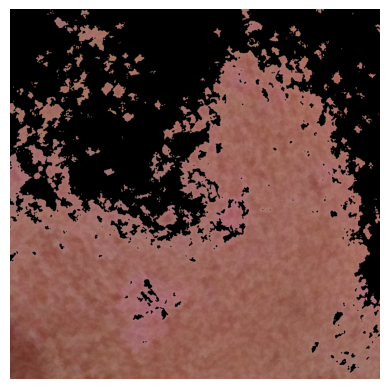

Total pixels: 99225
Mask pixels: 57863
Image test (2).png 
Expected coverage percentage: 13-18%. 
Computed coverage percentage: 58.314940791131264%



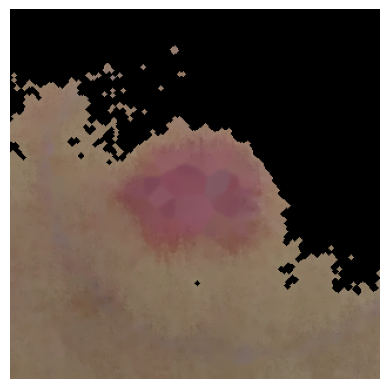

Total pixels: 285156
Mask pixels: 132711
Image test (3).png 
Expected coverage percentage: 40-50%. 
Computed coverage percentage: 46.53978874721205%



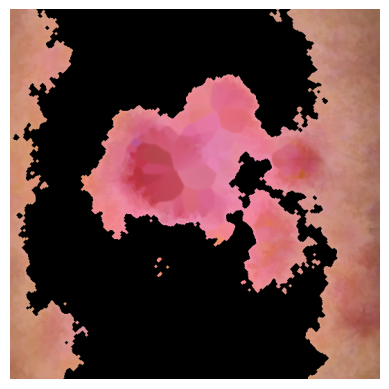

Total pixels: 61009
Mask pixels: 40281
Image test (4).png 
Expected coverage percentage: 15-30%. 
Computed coverage percentage: 66.02468488255832%



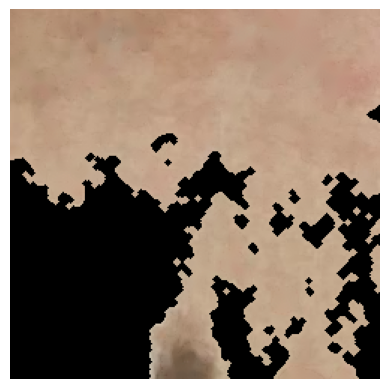

Total pixels: 1311025
Mask pixels: 754139
Image test (5).png 
Expected coverage percentage: 30-40%. 
Computed coverage percentage: 57.522854255258295%



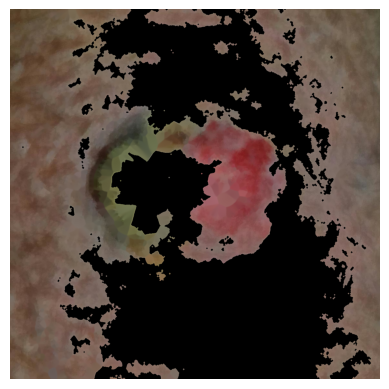

Total pixels: 731025
Mask pixels: 310562
Image test (6).png 
Expected coverage percentage: 13-18%. 
Computed coverage percentage: 42.48308881365207%



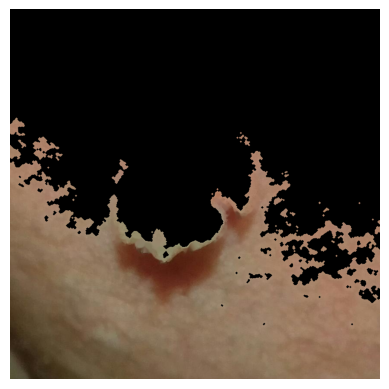

Total pixels: 611524
Mask pixels: 196924
Image test (7).png 
Expected coverage percentage: 40-50%. 
Computed coverage percentage: 32.20217031547413%



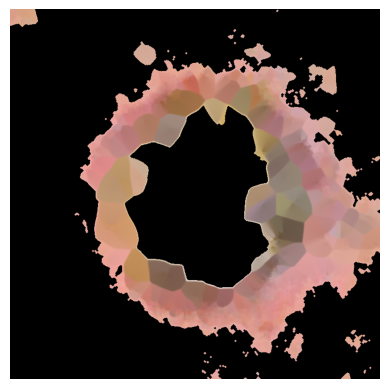

Total pixels: 504810
Mask pixels: 128871
Image test (8).png 
Expected coverage percentage: 10-15% (huge blue marks might be a problem). 
Computed coverage percentage: 25.528614726332684%



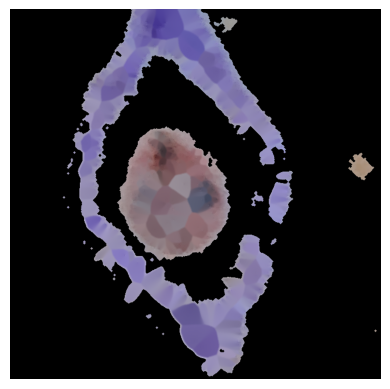

Total pixels: 224676
Mask pixels: 21964
Image test (9).png 
Expected coverage percentage: 15-20%. 
Computed coverage percentage: 9.775855008990725%



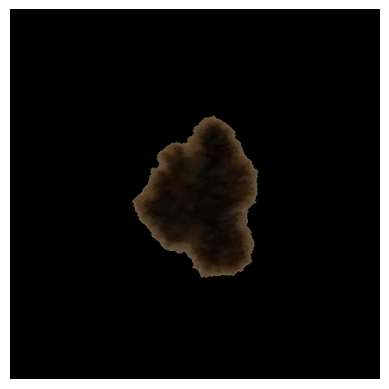

Total pixels: 3779136
Mask pixels: 2413411
Image test (10).png 
Expected coverage percentage: 5-10% (not noticeable + pen marks). 
Computed coverage percentage: 63.86144875442429%



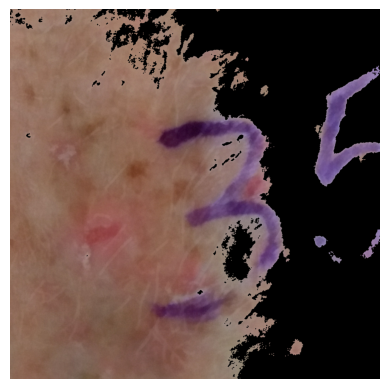

Total pixels: 599076
Mask pixels: 412984
Image test (11).png 
Expected coverage percentage: 10-15%. 
Computed coverage percentage: 68.9368293839179%



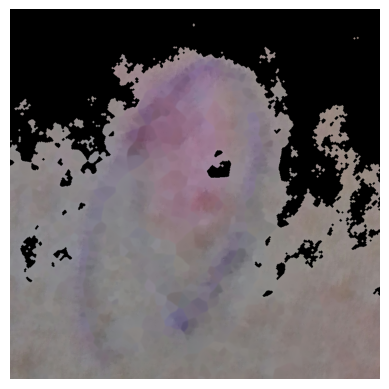

Total pixels: 6801664
Mask pixels: 786944
Image test (12).png 
Expected coverage percentage: 17-20%. 
Computed coverage percentage: 11.569874665964093%



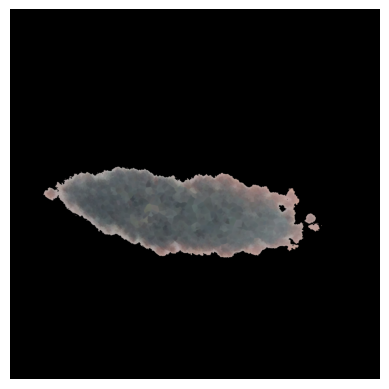

Total pixels: 414092
Mask pixels: 100007
Image test (13).png 
Expected coverage percentage: 25-40%. 
Computed coverage percentage: 24.150913323609245%



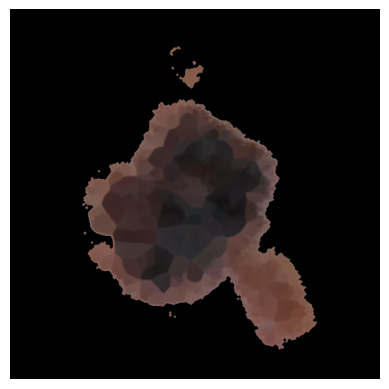

Total pixels: 586756
Mask pixels: 98351
Image test (14).png 
Expected coverage percentage: 20-25%. 
Computed coverage percentage: 16.761822631553834%



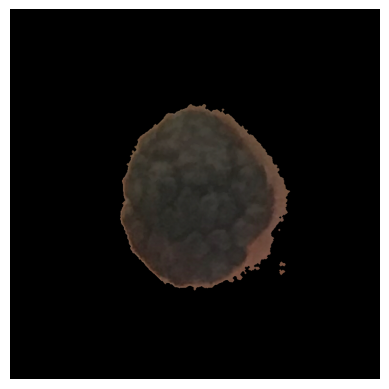

Total pixels: 1036324
Mask pixels: 27871
Image test (15).png 
Expected coverage percentage: 5-7%. 
Computed coverage percentage: 2.689409875675947%



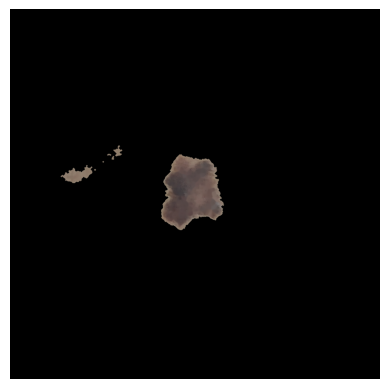

Total pixels: 804609
Mask pixels: 265193
Image test (16).png 
Expected coverage percentage: 15-20%. 
Computed coverage percentage: 32.95923858669242%



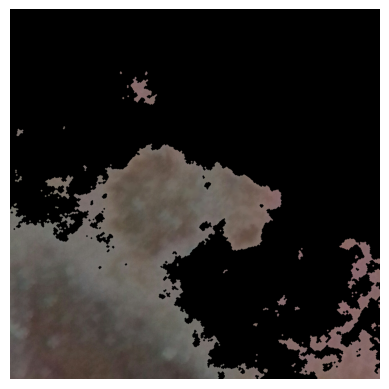

Total pixels: 2569609
Mask pixels: 1804525
Image test (17).png 
Expected coverage percentage: 50-60%. 
Computed coverage percentage: 70.22566468283696%



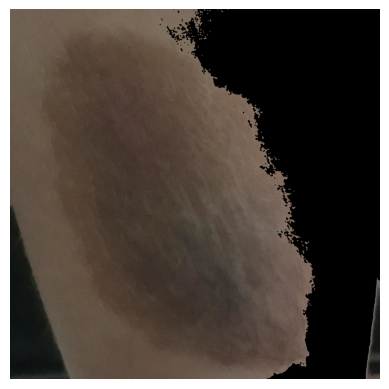

Total pixels: 1175056
Mask pixels: 554371
Image test (18).png 
Expected coverage percentage: 40-50%. 
Computed coverage percentage: 47.17826214240002%



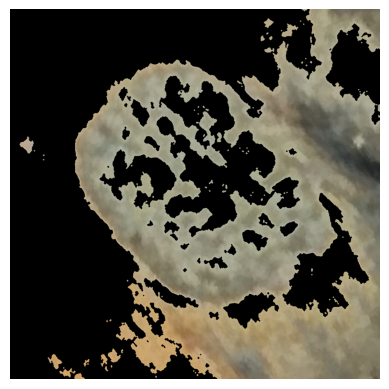

Total pixels: 142128
Mask pixels: 7039
Image test (19).png 
Expected coverage percentage: 5-10%. 
Computed coverage percentage: 4.952577957897107%



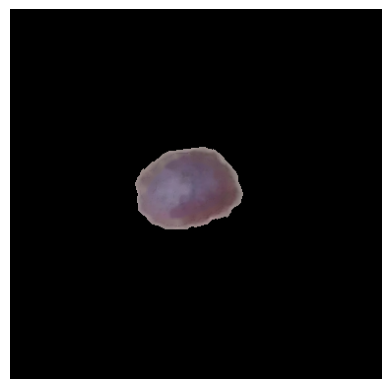

Total pixels: 3478225
Mask pixels: 109923
Image test (20).png 
Expected coverage percentage: 5-10%. 
Computed coverage percentage: 3.1603188407880456%



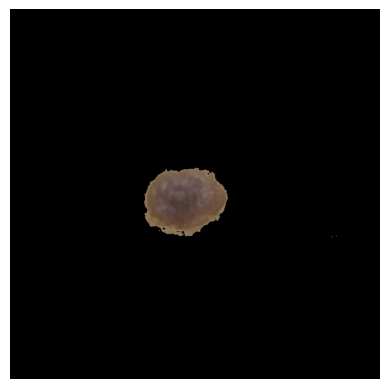

Total pixels: 1139556
Mask pixels: 263596
Image test (21).png 
Expected coverage percentage: 5-13%. 
Computed coverage percentage: 23.131465237338052%



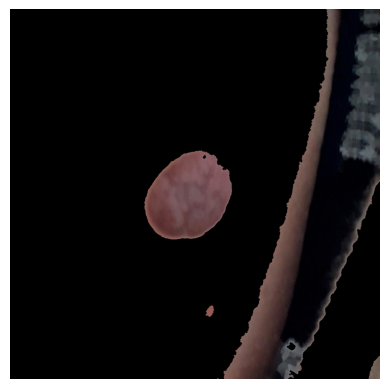

Total pixels: 1313316
Mask pixels: 748618
Image test (22).png 
Expected coverage percentage: 15-20%. 
Computed coverage percentage: 57.00212287065718%



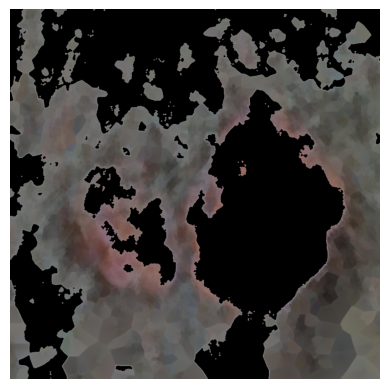

Total pixels: 90000
Mask pixels: 26325
Image test (23).png 
Expected coverage percentage: 45-55%. 
Computed coverage percentage: 29.25%



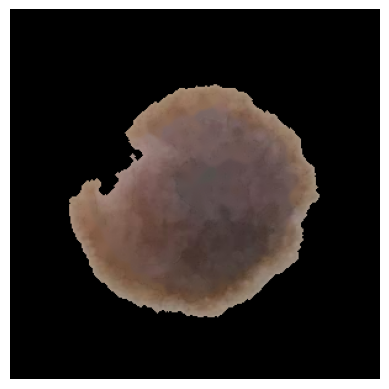

Total pixels: 161604
Mask pixels: 51830
Image test (24).png 
Expected coverage percentage: 10-20%. 
Computed coverage percentage: 32.07222593500161%



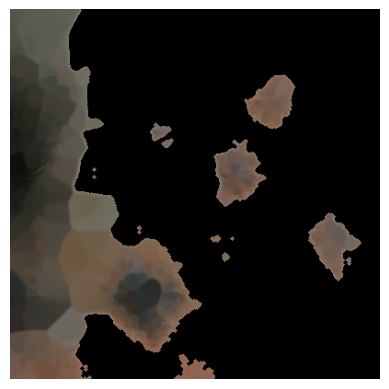

Total pixels: 65536
Mask pixels: 8992
Image test (25).png 
Expected coverage percentage: 15-22%. 
Computed coverage percentage: 13.720703125%



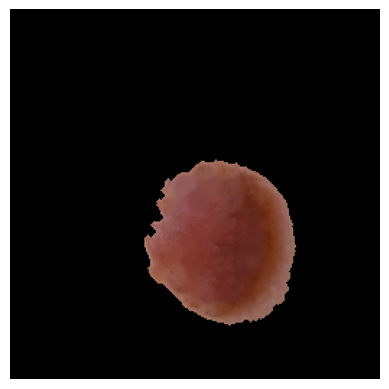

In [8]:
folder_path = "../../data/test"
i = 1

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1  # fallback if no number found

image_files = sorted(os.listdir(folder_path), key=extract_number)
 

# iterate through the images
for filename in image_files:

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    cov_perc, final_img = measure_pigment_network_maskapplier(img)

    print(f'Image {filename} \nExpected coverage percentage: {prediction[i]}. \nComputed coverage percentage: {cov_perc}%\n')
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()
    i += 1
    

## Test 3: blue pixels count
Result: works decently, even though some numbers are suspiciously big, but it's notably slow

In [9]:
def measure_blue_veil(image) -> int:
    """Computes the number of blue-ish pixels in the given (BGR) image.
    
    :param image: The BGR image to be analysed
    :return: integer representing the number of blue-ish pixels
    
    """

    # extract image dimensions
    height, width, _ = image.shape

    # initialize counter for number of blue veils
    count = 0

    # iterate through all the pixels in the image
    for y in range(height):
        for x in range(width):

            # extract color values from image
            b, g, r = image[y, x]

            # update counter if the pixel is teal, blue, purple
            if b > 60 and (r - 46 < g) and (g < r + 15):
                count += 1

    return count

In [10]:
image_files = sorted(os.listdir(folder_path), key=extract_number)
 

# iterate through the images
for filename in image_files:
    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    n_bpxl = measure_blue_veil(img)
    print(f'Image {filename}. Number of blue pixels: {n_bpxl}')

Image test (1).png. Number of blue pixels: 363409
Image test (2).png. Number of blue pixels: 91973
Image test (3).png. Number of blue pixels: 3750
Image test (4).png. Number of blue pixels: 60414
Image test (5).png. Number of blue pixels: 1149820
Image test (6).png. Number of blue pixels: 582498


KeyboardInterrupt: 

## Test 4: irregularity score extraction
Result: suspiciously too many zeros

In [45]:
def measure_streaks(image) -> int:
    """Computes the irregularity of the lesion in the given (BGR) image.
    
    :param image: The BGR image to be analysed
    :return: The irregularity score of the lesion

    """
   # get grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # compute threshold, using 11 neighbors
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # find the contours of the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # compute area and perimeter of the contours
    lesion_area = cv2.contourArea(contours[0])
    border_perimeter = cv2.arcLength(contours[0], True)

    # finally evaluate irregularity
    if lesion_area == 0:
        irregularity = 0
    else:
        irregularity = (border_perimeter ** 2) / (4 * np.pi * lesion_area)

    return irregularity

In [46]:
image_files = sorted(os.listdir(folder_path), key=extract_number)
 

# iterate through the images
for filename in image_files:
    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    irregularity_score = measure_streaks(img)
    print(f'Image {filename}. Irregularity score: {irregularity_score}')

Image test (1).png. Irregularity score: 0
Image test (2).png. Irregularity score: 0
Image test (3).png. Irregularity score: 0
Image test (4).png. Irregularity score: 0
Image test (5).png. Irregularity score: 0
Image test (6).png. Irregularity score: 1.2844010412034181
Image test (7).png. Irregularity score: 0
Image test (8).png. Irregularity score: 0
Image test (9).png. Irregularity score: 1.7497673457686571
Image test (10).png. Irregularity score: 0
Image test (11).png. Irregularity score: 0
Image test (12).png. Irregularity score: 0
Image test (13).png. Irregularity score: 0
Image test (14).png. Irregularity score: 0
Image test (15).png. Irregularity score: 0
Image test (16).png. Irregularity score: 0
Image test (17).png. Irregularity score: 4.66542156625653
Image test (18).png. Irregularity score: 0
Image test (19).png. Irregularity score: 0
Image test (20).png. Irregularity score: 0
Image test (21).png. Irregularity score: 0
Image test (22).png. Irregularity score: 0
Image test (23